# K-Means Clustering with Hadoop Streaming on Google Colab

This notebook installs Hadoop (with Hadoop Streaming) and runs a k‑means clustering algorithm using a MapReduce approach. In each iteration:

- **Mapper:** Loads current centroids from `centroids.txt`, assigns each data point (from `data.txt`) to its nearest centroid, computes the squared Euclidean distance (the WCSS contribution), and emits:
`<centroid_index> <tab> <point_vector> <tab> 1 <tab> <squared_distance>`

- **Reducer:** Aggregates the mapper outputs per centroid to compute the new centroids (by averaging points) and sums the total WCSS for the cluster.

The algorithm repeats until either the relative change in total WCSS falls below a specified threshold or a maximum number of iterations is reached.


In [3]:
# Update package lists and install OpenJDK 8 (needed by Hadoop)
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [4]:
# Download Hadoop 3.3.5 (adjust version if needed)
!wget https://downloads.apache.org/hadoop/common/hadoop-3.3.5/hadoop-3.3.5.tar.gz

--2025-03-19 22:17:09--  https://downloads.apache.org/hadoop/common/hadoop-3.3.5/hadoop-3.3.5.tar.gz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.208.237, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 706533213 (674M) [application/x-gzip]
Saving to: ‘hadoop-3.3.5.tar.gz’

hadoop-3.3.5.tar.gz 100%[===================>] 673.80M  20.5MB/s    in 36s     

2025-03-19 22:17:45 (18.7 MB/s) - ‘hadoop-3.3.5.tar.gz’ saved [706533213/706533213]



In [5]:
# Extract Hadoop tarball
!tar -xzf hadoop-3.3.5.tar.gz

# Move Hadoop to /usr/local/
!mv hadoop-3.3.5/ /usr/local/

In [6]:
!ls /usr/local

bin    cuda	cuda-12.5	  etc	 hadoop-3.3.5  lib	LICENSE.md  opt   share
colab  cuda-12	dist_metrics.pxd  games  include       libexec	man	    sbin  src


**Environment Variables**

In [7]:
 import os
 # Set JAVA_HOME to use Java 8
 os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
 # Set HADOOP_HOME to the installed Hadoop directory
 os.environ["HADOOP_HOME"] = "/usr/local/hadoop-3.3.5/"

In [8]:
 !echo $PATH

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [9]:
 # Add Hadoop BIN to PATH
 current_path = os.getenv('PATH')
 new_path = current_path+':/usr/local/hadoop-3.3.5/bin/'
 os.environ["PATH"] = new_path
 # Verify that Hadoop bin is in PATH
 !echo $PATH

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/usr/local/hadoop-3.3.5/bin/


In [10]:
# This cell searches for the Hadoop Streaming jar.
# It is used by Hadoop to run Python scripts as mapper and reducer.
!find / -name 'hadoop-streaming*.jar'

/usr/local/hadoop-3.3.5/share/hadoop/tools/sources/hadoop-streaming-3.3.5-sources.jar
/usr/local/hadoop-3.3.5/share/hadoop/tools/sources/hadoop-streaming-3.3.5-test-sources.jar
/usr/local/hadoop-3.3.5/share/hadoop/tools/lib/hadoop-streaming-3.3.5.jar
find: ‘/proc/69/task/69/net’: Invalid argument
find: ‘/proc/69/net’: Invalid argument


In [11]:
# Making sure the mapper and reducer scripts are executable.
!chmod u+rwx mapper.py
!chmod u+rwx reducer.py

# List the files to verify they exist.
!ls -l mapper.py reducer.py

-rwxr--r-- 1 root root 2201 Mar 19 22:16 mapper.py
-rwxr--r-- 1 root root 2206 Mar 19 22:16 reducer.py


In [12]:
import os
import random

# Create a sample data file (data.txt) if it doesn't exist.
# Each line is a comma-separated list representing a data point
if not os.path.exists("data.txt"):
    with open("data.txt", "w") as f:
        for _ in range(100):
            # Generate random 2D points in the range [0, 100)
            x = random.uniform(0, 100)
            y = random.uniform(0, 100)
            f.write(f"{x},{y}\n")

# Create an initial centroids file (centroids.txt) if it doesn't exist.
# randomly select 3 points from data.txt as initial centroids.
if not os.path.exists("centroids.txt"):
    with open("data.txt", "r") as f:
        lines = f.readlines()
    initial_centroids = random.sample(lines, 3)
    with open("centroids.txt", "w") as f:
        for i, line in enumerate(initial_centroids):
            point = line.strip()  # e.g., "12.3,45.6"
            f.write(f"{i}\t{point}\n")

In [1]:
import os

def run_mapreduce_iteration(iteration):
    """
    Executes one iteration of the k-means MapReduce process using Hadoop Streaming.

    Parameters:
      iteration (int): The current iteration number (used to create a unique output directory).

    Returns:
      total_wcss (float): The aggregated Within-Cluster Sum of Squares for this iteration.
    """
    # Define a unique output directory for this iteration.
    output_dir = f"/content/iter_out_{iteration}"

    # Remove any existing output directory.
    os.system(f"rm -rf {output_dir}")

    # Build and run the Hadoop Streaming command.
    # -files sends centroids.txt along with the job so that the mapper can access it.
    cmd = (
        "hadoop jar /usr/local/hadoop-3.3.5/share/hadoop/tools/lib/hadoop-streaming-3.3.5.jar "
        f"-files centroids.txt -input /content/data.txt -output {output_dir} "
        "-mapper 'python mapper.py' -reducer 'python reducer.py'"
    )
    print(f"Running Hadoop Streaming command:\n{cmd}")
    os.system(cmd)

    # Parse reducer output to compute the total WCSS and capture new centroids.
    total_wcss = 0.0
    new_centroids = {}
    reducer_output = f"{output_dir}/part-00000"

    if not os.path.exists(reducer_output):
        raise Exception(f"Reducer output not found at {reducer_output}")

    with open(reducer_output, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Expected format: <centroid_index>\t<new_centroid_str>\t<total_wcss>
            parts = line.split("\t")
            if len(parts) != 3:
                continue
            try:
                centroid_index = int(parts[0])
                centroid_str = parts[1]
                wcss = float(parts[2])
            except Exception as e:
                print("Error parsing line:", line, e)
                continue
            new_centroids[centroid_index] = centroid_str
            total_wcss += wcss

    # Update centroids.txt for the next iteration.
    with open("centroids.txt", "w") as f:
        for idx, centroid_str in new_centroids.items():
            f.write(f"{idx}\t{centroid_str}\n")

    return total_wcss


In [13]:
max_iterations = 20      # Maximum iterations allowed.
threshold = 0.001        # Convergence threshold (relative change in total WCSS).
prev_wcss = None

for iteration in range(max_iterations):
    print(f"\nIteration {iteration + 1}")
    curr_wcss = run_mapreduce_iteration(iteration)
    print(f"Total WCSS: {curr_wcss}")

    if prev_wcss is not None:
        relative_change = abs(prev_wcss - curr_wcss) / prev_wcss
        print(f"Relative change: {relative_change:.4f}")
        if relative_change < threshold:
            print("Convergence reached.")
            break

    prev_wcss = curr_wcss


Iteration 1
Running Hadoop Streaming command:
hadoop jar /usr/local/hadoop-3.3.5/share/hadoop/tools/lib/hadoop-streaming-3.3.5.jar -files centroids.txt -input /content/data.txt -output /content/iter_out_0 -mapper 'python mapper.py' -reducer 'python reducer.py'
Total WCSS: 29170.280682844445

Iteration 2
Running Hadoop Streaming command:
hadoop jar /usr/local/hadoop-3.3.5/share/hadoop/tools/lib/hadoop-streaming-3.3.5.jar -files centroids.txt -input /content/data.txt -output /content/iter_out_1 -mapper 'python mapper.py' -reducer 'python reducer.py'
Total WCSS: 12439.340765436013
Relative change: 0.5736

Iteration 3
Running Hadoop Streaming command:
hadoop jar /usr/local/hadoop-3.3.5/share/hadoop/tools/lib/hadoop-streaming-3.3.5.jar -files centroids.txt -input /content/data.txt -output /content/iter_out_2 -mapper 'python mapper.py' -reducer 'python reducer.py'
Total WCSS: 12204.159261588906
Relative change: 0.0189

Iteration 4
Running Hadoop Streaming command:
hadoop jar /usr/local/hado

In [14]:
print("Final centroids:")
with open("centroids.txt", "r") as f:
    print(f.read())

Final centroids:
0	-0.2494776970530015,0.04474205209066079
1	19.95688303162847,7.516982758905519
2	9.555298702442007,17.766757840999276



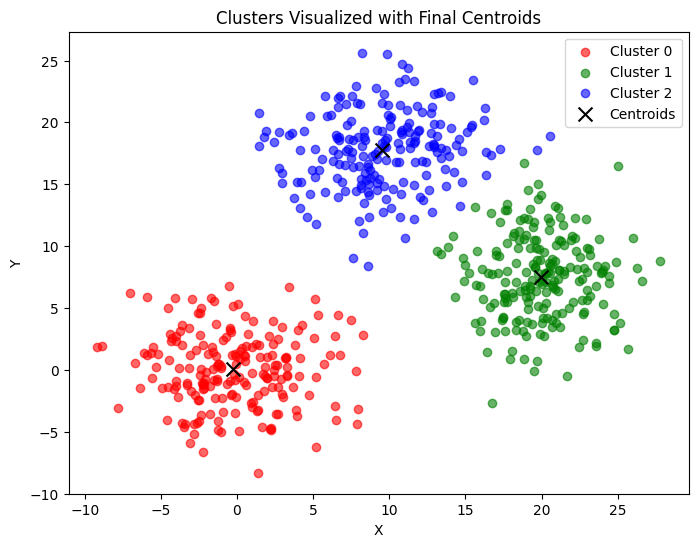

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load unlabeled data points
data = np.loadtxt("data.txt", delimiter=",")

# Load final centroids from centroids.txt
# Each line is in the format: <centroid_index>\t<centroid_vector>
centroids = {}
with open("centroids.txt", "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split("\t")
        idx = int(parts[0])
        centroid = np.array([float(x) for x in parts[1].split(",")])
        centroids[idx] = centroid

# Sort centroids by index for consistency
centroid_indices = sorted(centroids.keys())
centroid_array = np.array([centroids[i] for i in centroid_indices])

# Function to assign each data point to the nearest centroid
def assign_cluster(point, centroids):
    distances = [np.linalg.norm(point - centroids[i]) for i in centroid_indices]
    return centroid_indices[np.argmin(distances)]

# Get cluster assignments for all data points
cluster_assignments = np.array([assign_cluster(point, centroids) for point in data])
unique_clusters = np.unique(cluster_assignments)

# Define a set of colors for plotting clusters
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta']

plt.figure(figsize=(8, 6))
for i, cluster in enumerate(unique_clusters):
    cluster_points = data[cluster_assignments == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                color=colors[i % len(colors)], alpha=0.6,
                label=f"Cluster {cluster}")

# Plot the centroids as black X's
plt.scatter(centroid_array[:, 0], centroid_array[:, 1],
            color='black', marker='x', s=100, label="Centroids")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Clusters Visualized with Final Centroids")
plt.legend()
plt.show()

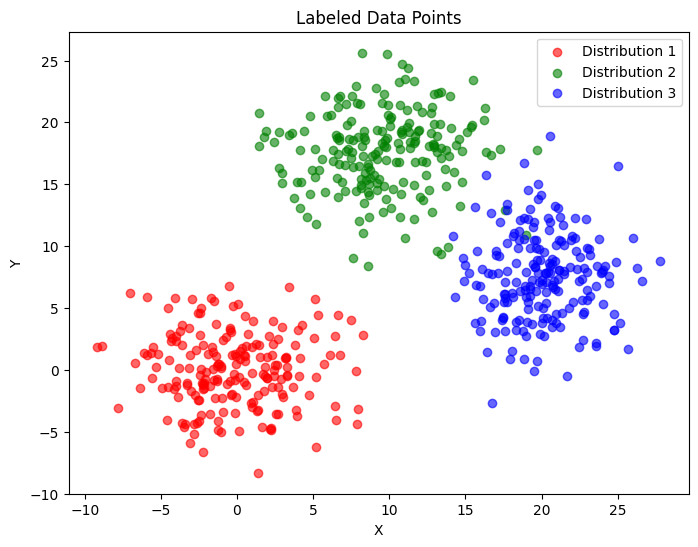

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Load the labeled data
# Each line is in the format: x,y,label
labeled_data = np.loadtxt("data_with_labels.txt", delimiter=",")

# Separate the columns: x, y, and label
x = labeled_data[:, 0]
y = labeled_data[:, 1]
labels = labeled_data[:, 2].astype(int)

unique_labels = np.unique(labels)
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta']

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    subset = labeled_data[labels == label]
    plt.scatter(subset[:, 0], subset[:, 1],
                color=colors[i % len(colors)], alpha=0.6,
                label=f"Distribution {label}")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Labeled Data Points")
plt.legend()
plt.show()
